<a href="https://colab.research.google.com/github/anu04596/DeepLearningTuotorial/blob/main/Day14(Saving).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning Validation and Saving Model

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Transform and Load CIFAR- 10

In [2]:
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 29.8MB/s]


In [4]:
train_idx, val_idx=train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)

train_sampler=SubsetRandomSampler(train_idx)
val_sampler=SubsetRandomSampler(val_idx)

train_loader=DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader=DataLoader(train_dataset, batch_size=64, sampler=val_sampler)
test_loader=DataLoader(test_dataset, batch_size=64, shuffle=False)

Model : ResNet18

In [5]:
from torchvision.models import resnet18

model=resnet18(pretrained=False)

model.fc=nn.Linear(model.fc.in_features, 10)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loss and Optimizer

In [7]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

Train Function

In [11]:
def train(model, loader):
  model.train()
  running_loss=0
  for images , labels in train_loader:
    images, labels =images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  return running_loss/len(loader)

Evalaution Function

In [9]:
def evalaute(model, loader):
  model.eval()
  total, correct=0,0
  running_loss=0

  with torch.no_grad():
    for x,y in loader:
      x,y=x.to(device), y.to(device)
      output=model(x)
      loss=criterion(output, y)
      running_loss+=loss.item()

      _, predicted=torch.max(output.data, 1)
      total+=y.size(0)
      correct+=(predicted==y).sum().item()

  return running_loss/len(loader), 100*correct/total

Training

In [13]:
train_losses,val_losses, val_accuracies=[],[],[]

for epoch in range(5):
  train_loss=train(model,train_loader)
  val_loss,val_acc=evalaute(model, val_loader)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)
  print(f'Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')

Epoch 1/5, Train Loss: 1.3695, Val Loss: 1.3748, Val Accuracy: 50.43%
Epoch 2/5, Train Loss: 1.1571, Val Loss: 1.1194, Val Accuracy: 59.54%
Epoch 3/5, Train Loss: 1.0315, Val Loss: 1.0517, Val Accuracy: 62.79%
Epoch 4/5, Train Loss: 0.9406, Val Loss: 0.9737, Val Accuracy: 66.45%
Epoch 5/5, Train Loss: 0.8625, Val Loss: 0.9107, Val Accuracy: 68.22%


Loss and accuracy plots

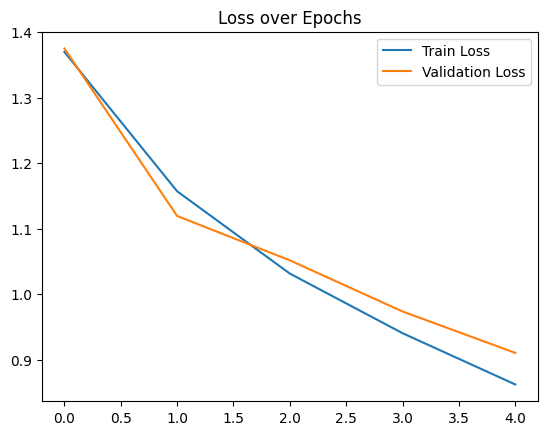

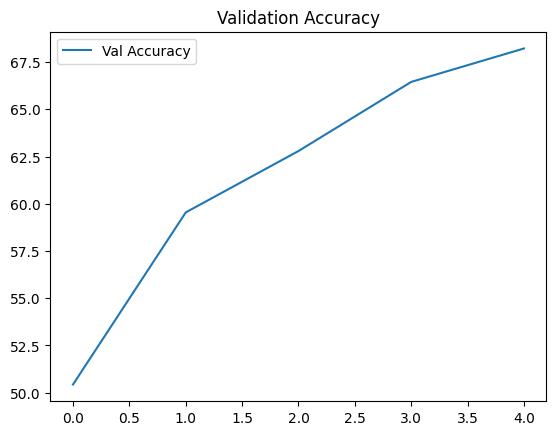

In [14]:
plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.show()

Save and load model

In [15]:
torch.save(model.state_dict(), 'model.pth')